<a href="https://colab.research.google.com/github/RiboRings/neurogenomics/blob/main/project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Part 1 - Normalization of sequencing data

## Part A: TMM Normalization

In [11]:
pasilla = pd.read_csv("/content/pasilla_gene_counts.tsv", sep="\t", index_col=0)

In [13]:
def TMM_normalization(X, Y, D=0.2):

  idx0 = np.where((X != 0) & (Y != 0))
  X = X[idx0]
  Y = Y[idx0]

  M = np.log(Y / X)
  Wi = np.sqrt((X + Y) / 2)

  lower_quantile = np.quantile(M, D/2)
  upper_quantile = np.quantile(M, 1 - D / 2)

  D2 = np.where((M > lower_quantile) & (M < upper_quantile))
  trimed_m = M[D2]
  trimed_Wi = Wi[D2]

  sorted_idx = np.argsort(trimed_m)
  sorted_m = trimed_m[sorted_idx]
  sorted_w = trimed_Wi[sorted_idx]

  tmm = np.sum(sorted_w * sorted_m) / np.sum(sorted_w)
  factor = np.exp(tmm)
  normalized_Y = Y / factor

  fig, axes = plt.subplots(1, 2, sharey=True)

  fig.set_figwidth(10)
  fig.set_figheight(3)

  axes[0].hist(X, bins=100, range=[0, 1000], histtype="step", label="X")
  axes[0].hist(Y, bins=100, range=[0, 1000], histtype="step", label="Y")

  axes[0].set_xlabel("Gene Expression")
  axes[0].set_ylabel("Gene Count")
  axes[0].set_title("Vectors histogram before normalization")
  axes[0].legend()

  axes[1].hist(X, bins=100, range=[0, 1000], histtype="step", label="X")
  axes[1].hist(normalized_Y, bins=100, range=[0, 1000], histtype="step", label="Normalized_Y")

  axes[1].set_xlabel("Gene Expression")
  axes[1].set_title("Vectors histogram after normalization")
  axes[1].legend()

  plt.tight_layout()

  return X, normalized_Y, factor

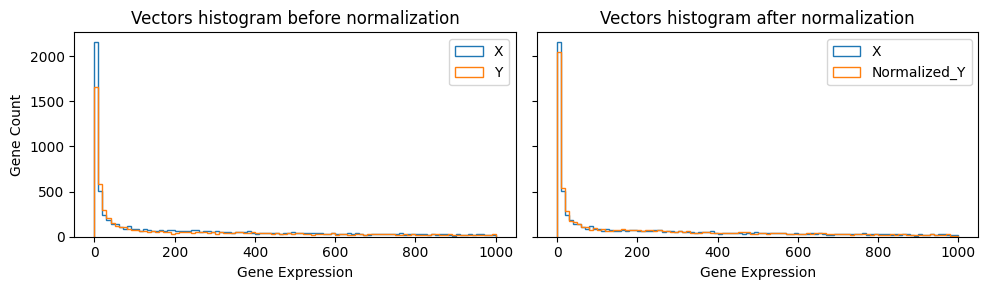

In [14]:
X = pasilla["untreated1"].to_numpy()
Y = pasilla["untreated2"].to_numpy()

X, norm_Y, factor = TMM_normalization(X, Y)

Quantile normalization

## Part B: Quantile Normalisation

In [15]:
def quantile_normalisation(X, Y):

  A = np.vstack([X, Y]).T

  order = A.argsort(axis=0)
  ranks = order.argsort(axis=0)

  sorted_A = np.sort(A, axis=0)
  row_mean = np.mean(sorted_A, axis=1)

  norm_A = np.zeros_like(A).astype(float)

  for rank in range(row_mean.size):

    norm_A[ranks == rank] = row_mean[rank]

  norm_X, norm_Y = norm_A[:, 0], norm_A[:, 1]

  fig, axes = plt.subplots(1, 2, sharey=True)

  fig.set_figwidth(10)
  fig.set_figheight(3)

  axes[0].hist(X, bins=100, range=[0, 1000], histtype="step", label="X")
  axes[0].hist(Y, bins=100, range=[0, 1000], histtype="step", label="Y")

  axes[0].set_xlabel("Gene Expression")
  axes[0].set_ylabel("Gene Count")
  axes[0].set_title("Vectors histogram before normalization")
  axes[0].legend()

  axes[1].hist(norm_X, bins=100, range=[0, 1000], histtype="step", label="Normalized_X")
  axes[1].hist(norm_Y, bins=100, range=[0, 1000], histtype="step", label="Normalized_Y")

  axes[1].set_xlabel("Gene Expression")
  axes[1].set_title("Vectors histogram after normalization")
  axes[1].legend()

  plt.tight_layout()

  return norm_X, norm_Y

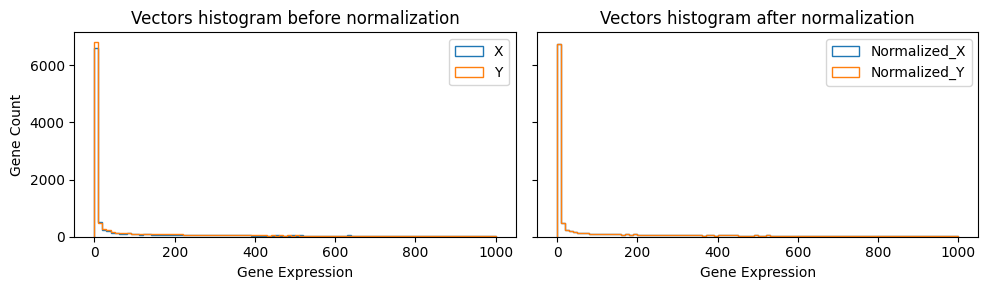

In [16]:
pasilla = pd.read_csv("/content/pasilla_gene_counts.tsv", sep="\t", index_col=0)
X = pasilla["untreated1"].to_numpy()
Y = pasilla["treated2"].to_numpy()

norm_X, norm_Y = quantile_normalisation(X, Y)

# Part 2

In [49]:
circ_df = pd.read_csv("CircadianRNAseq.csv")

circ_df.index = circ_df['GeneSymbol'].astype('str').str.cat(circ_df.groupby('GeneSymbol').cumcount().add(1).astype('str'), sep='_')
circ_df = circ_df.drop(columns=["RefSeqID", "GeneSymbol"])
circ_mat = circ_df.to_numpy()

In [89]:
p

array([[   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       [   0.        ,    0.        ,    0.        ,    0.        ,
           0.        ,    0.        ],
       ...,
       [  75.72834363,   34.41869301,   10.82228018,   96.97296661,
          52.72542871,   67.026969  ],
       [3948.30461476, 1279.86650071, 1011.1545193 ,  243.94857319,
        1104.55403614,  631.919044  ],
       [   9.85321523,  193.63393828,  132.58661805,   84.80002804,
         131.42336005,    8.85955225]])

In [111]:
powers = fft(circ_mat, axis=1)
powers = np.abs(powers) ** 2

powers = powers[:, 1:(1 + powers.shape[1] // 2)]
norm_powers = powers / np.nansum(powers, axis=1, keepdims=True)

norm_powers[:, 1]

<ipython-input-111-fa6be643ccdb>:5: RuntimeWarning: invalid value encountered in divide
  norm_powers = powers / np.nansum(powers, axis=1, keepdims=True)


array([       nan,        nan,        nan, ..., 0.10192252, 0.15570631,
       0.34506214])

In [113]:
from scipy.fftpack import fft

def compute_powers(mat):  # Compute G factors

  powers = fft(mat, axis=1)
  powers = np.abs(powers) ** 2

  powers = powers[:, 1:(1 + powers.shape[1] // 2)]
  norm_powers = powers / np.nansum(powers, axis=1, keepdims=True)

  circ_powers = norm_powers[:, 1]
  circ_powers = circ_powers[~np.isnan(circ_powers)]
  sorted_powers = np.sort(circ_powers)[::-1]

  return circ_powers

<ipython-input-113-ca54a6e062f1>:9: RuntimeWarning: invalid value encountered in divide
  norm_powers = powers / np.nansum(powers, axis=1, keepdims=True)


Text(0.5, 1.0, 'G factor per amount')

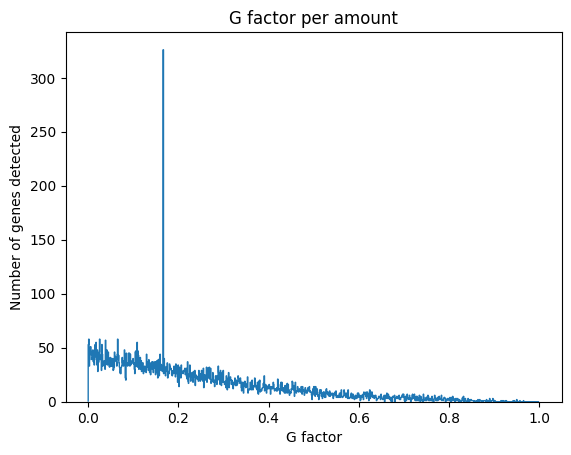

In [117]:
circ_powers = compute_powers(circ_mat)

# Create and plot the G factor array
G_factor_array, _, _ = plt.hist(circ_powers, bins=1000, range=[0, 1], histtype="step")

plt.xlabel("G factor")
plt.ylabel("Number of genes detected")
plt.title("G factor per amount")

In [125]:
def shuffle_along_axis(mat, axis):

    idx = np.random.rand(*mat.shape).argsort(axis=axis)
    shuffled_mat = np.take_along_axis(mat, idx, axis=axis)

    return shuffled_mat

Text(0.5, 1.0, 'G factor per amount')

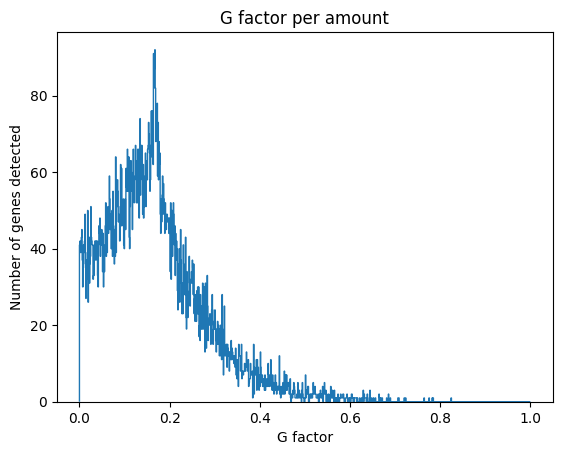

In [142]:
shuffled_mat = shuffle_along_axis(circ_mat, axis=0)
shuffled_powers = compute_powers(shuffled_mat)

# Create and plot the G factor array
G_factor_array, _, _ = plt.hist(shuffled_powers, bins=1000, range=[0, 1], histtype="step")

plt.xlabel("G factor")
plt.ylabel("Number of genes detected")
plt.title("G factor per amount")

In [140]:
power_list = []

for i in range(100):

  shuffled_mat = shuffle_along_axis(circ_mat, axis=0)
  shuffled_powers = compute_powers(shuffled_mat)

  power_list.append(shuffled_powers)

power_arr = np.array(power_list)

Text(0.5, 1.0, 'G factor per amount')

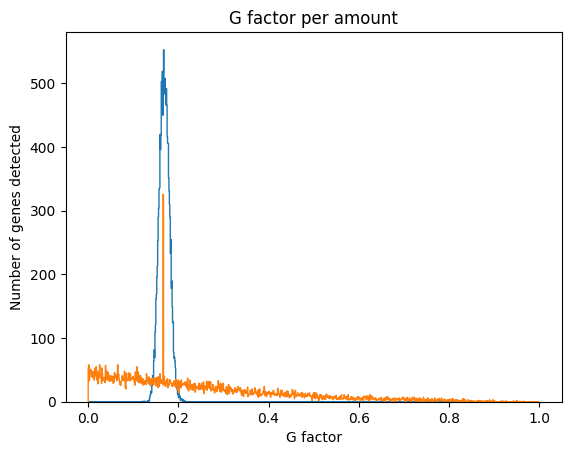

In [147]:
mean_powers = np.mean(power_arr, axis=0)
a, _, _ = plt.hist(mean_powers, bins=1000, range=[0, 1], histtype="step")
plt.hist(circ_powers, bins=1000, range=[0, 1], histtype="step")

plt.xlabel("G factor")
plt.ylabel("Number of genes detected")
plt.title("G factor per amount")